In [1]:
import os
import pandas as pd

from tqdm.notebook import tqdm

from pyphylon.downloads import download_genomes_bvbrc
from pyphylon.util import load_config

In [2]:
CONFIG = load_config("config.yml")
WORKDIR = CONFIG["WORKDIR"]
SPECIES = CONFIG["PG_NAME"]

# Select Strains for Affinity Inference

Select strains for which to infer affinities. Place these strains as .fna files into the directory `/examples/data/inferring_affinities/input_strains`.

Below, 5 strains are downloaded as an example.

In [3]:
# Make output directories
INFERRING_AFFINITIES = os.path.join(WORKDIR, 'inferring_affinities')
OUTPUT_DIR = os.path.join(INFERRING_AFFINITIES, "input_strains")
if not os.path.exists(INFERRING_AFFINITIES):
    os.makedirs(INFERRING_AFFINITIES)

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [4]:
genomes_to_download = [
'1115817.3',
'1115814.3',
'1115827.3',
'1115819.3',
'1115812.3',
]

In [5]:
bad_genomes = download_genomes_bvbrc(
    genomes=genomes_to_download,
    output_dir=OUTPUT_DIR,
    filetypes=['fna']
)

Processing filetypes...:   0%|          | 0/1 [00:00<?, ?it/s]

2025-05-19 15:15:22,280 - INFO - File data/inferring_affinities\input_strains\fna\1115817.3.fna already exists and force is False. Skipping download.
2025-05-19 15:15:22,281 - INFO - File data/inferring_affinities\input_strains\fna\1115814.3.fna already exists and force is False. Skipping download.
2025-05-19 15:15:22,281 - INFO - File data/inferring_affinities\input_strains\fna\1115827.3.fna already exists and force is False. Skipping download.
2025-05-19 15:15:22,282 - INFO - File data/inferring_affinities\input_strains\fna\1115819.3.fna already exists and force is False. Skipping download.
2025-05-19 15:15:22,282 - INFO - File data/inferring_affinities\input_strains\fna\1115812.3.fna already exists and force is False. Skipping download.


Removing bad genome files...: 0it [00:00, ?it/s]

# Run Script to Combine Sequences with the CD-HIT Pangenome

Following the same protocol as the README describes, run the Snakefile in `workflow/infer_affinities` to assess new strains against the pangenome by first running MASH and CD-HIT-2D.

# Analyze the Results

## Load Data

In [6]:
# Load in (full) P matrix
df_genes = pd.read_pickle(os.path.join(WORKDIR, f'processed/cd-hit-results/{SPECIES}_strain_by_gene.pickle.gz'))

# Load in metadata
ENRICHED_METADATA = os.path.join(WORKDIR, 'interim/enriched_metadata_2d.csv')
# Load in (full) metadata
metadata = pd.read_csv(ENRICHED_METADATA, index_col=0, dtype='object')

# Filter metadata for Complete sequences only
metadata = metadata[metadata.genome_status == 'Complete'] # filter for only Complete sequences

# Filter P matrix for Complete sequences only
df_genes_complete = df_genes[metadata.genome_id].copy()
df_genes_complete.fillna(0, inplace=True) # replace N/A with 0
df_genes_complete = df_genes_complete.sparse.to_dense().astype('int8') # densify & typecast to int8 for space and compute reasons
inCompleteseqs = df_genes_complete.sum(axis=1) > 0 # filter for genes found in complete sequences
df_genes_complete = df_genes_complete[inCompleteseqs]

metadata = metadata.set_index('genome_id')

L_BIN = os.path.join(WORKDIR, 'processed/nmf-outputs/L_binarized.csv')
L_binarized = pd.read_csv(L_BIN, index_col=0)

L_NORM = os.path.join(WORKDIR, 'processed/nmf-outputs/L_norm.csv')
L_norm = pd.read_csv(L_NORM, index_col=0)

A_NORM = os.path.join(WORKDIR, 'processed/nmf-outputs/A_norm.csv')
A_norm = pd.read_csv(A_NORM, index_col=0)

## Classify new strains against MASH clusters

In [7]:
MASH_DISTANCES = os.path.join(WORKDIR, 'inferring_affinities', 'combined_mash_distances.csv')

mash_distances = pd.read_csv(MASH_DISTANCES, dtype = 'object').set_index('genome_id').astype(float)

In [8]:
strain_mash_clusters = pd.DataFrame(columns = ['best_cluster', 'nearest_mash_distance_mean'])

for new_strain in mash_distances.columns:
    top_distances = mash_distances[new_strain].sort_values().index[:5] # get 5 closest strains
    mash_cluster = int(float(metadata.loc[top_distances]['mash_cluster'].value_counts().idxmax()))
    strain_mash_clusters.loc[new_strain] = [mash_cluster,
                                            mash_distances[new_strain].sort_values().head(5).mean()]

In [9]:
strain_mash_clusters

,best_cluster,nearest_mash_distance_mean
1115812.3_distances,2.0,0.011445
1115814.3_distances,17.0,0.009936
1115817.3_distances,3.0,0.007297
1115819.3_distances,3.0,0.004689
1115827.3_distances,8.0,0.011389


## Assign Phylon Affinities

In [10]:
from pyphylon.infer_affinities import *
from pyphylon.models import recommended_threshold
import seaborn as sns

In [19]:
L_norm

,phylon0,phylon1,phylon2,phylon3,phylon4,phylon5
SPyogenes_C229,0.022316,0.000000,0.002094,0.805342,0.000000,0.000000
SPyogenes_C448,0.376570,0.017068,0.120379,0.845740,0.000000,0.139285
SPyogenes_C2216,0.995822,0.931153,0.897150,0.000000,0.943714,0.804242
SPyogenes_C3484,0.859330,0.924933,0.859594,0.733048,0.928510,0.817885
SPyogenes_C536,0.971640,0.933592,0.896995,0.000000,0.949662,0.716580
...,...,...,...,...,...,...
SPyogenes_C446,1.026319,0.937260,0.877735,0.905245,0.944865,0.234131
SPyogenes_C4062,0.197095,0.000000,0.120058,0.854579,0.000000,0.000000
SPyogenes_C3361,0.995822,0.931153,0.897150,0.000000,0.943714,0.804242
SPyogenes_C3799,0.007238,0.000000,1.000625,0.000000,0.000000,0.092417


In [ ]:
P_NEW = os.path.join(WORKDIR, 'inferring_affinities', 'combined_P_matrix.csv')
P_new = pd.read_csv(P_NEW, index_col=0)
P_new = P_new.reindex(df_genes.index, fill_value=0)

# P_new_acc = P_new.loc[L_norm.index]

P_new_acc = P_new.loc[list(set(L_norm.index.tolist())&set(P_new.index.tolist()))] # without this i get an error that 7 genes in L_norm are not in P_new
L_norm2 = L_norm.loc[list(set(L_norm.index.tolist())&set(P_new.index.tolist()))] # to make dimension match...

KeyError: "['SPyogenes_C398', 'SPyogenes_C2357', 'SPyogenes_C801', 'SPyogenes_C3052', 'SPyogenes_C872', 'SPyogenes_C284', 'SPyogenes_C8'] not in index"

In [26]:
A_new = infer_affinities(L_norm2.to_numpy(),  P_new_acc.to_numpy(), n_jobs=4)
A_new = pd.DataFrame(A_new, index = L_norm.columns, columns = P_new_acc.columns)

  0%|          | 0/5 [00:00<?, ?it/s]

<Axes: >

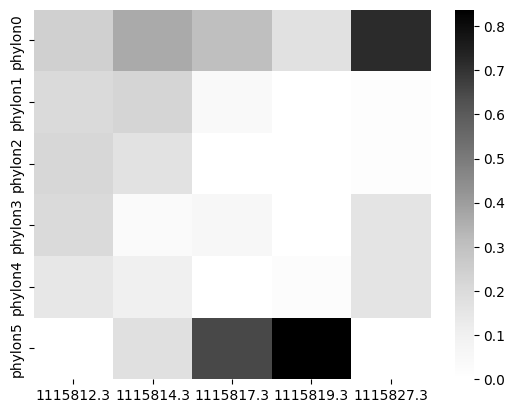

In [27]:
# Basic binarization with thresholds from original matrix:
A_binarized_new = pd.DataFrame(np.zeros_like(A_new.values), index=A_norm.index, columns=A_new.columns)


for idx in A_norm.index: # 90% of threshold for original A matrix used to account for CD-HIT clustering incongruities on strains
    cond = A_new.loc[idx] >= recommended_threshold(A_norm, idx.split('n')[1]) * .9
    A_binarized_new.loc[idx,cond] = 1

sns.heatmap(A_new, cmap='Greys')